In [5]:
import numpy as np
import os
import glob
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import pickle
from keras.utils import to_categorical

from keras import backend as K
import keras
from keras.layers import *
from keras.callbacks import *
from keras.models import *
from keras.losses import *
from keras.optimizers import *

In [6]:
# FIG_WIDTH=20 # Width of figure
# ROW_HEIGHT=3 # Height of each row when showing a figure which consists of multiple rows
RESIZE_DIM=28 # The images will be resized to 28x28 pixels

In [7]:
data_dir=os.path.join('..','input/numta')
paths_train_a=glob.glob(os.path.join(data_dir,'training-a','*.png'))
paths_train_b=glob.glob(os.path.join(data_dir,'training-b','*.png'))
paths_train_e=glob.glob(os.path.join(data_dir,'training-e','*.png'))
paths_train_c=glob.glob(os.path.join(data_dir,'training-c','*.png'))
paths_train_d=glob.glob(os.path.join(data_dir,'training-d','*.png'))
paths_train_all=paths_train_a+paths_train_b+paths_train_c+paths_train_d+paths_train_e

paths_test_a=glob.glob(os.path.join(data_dir,'testing-a','*.png'))
paths_test_b=glob.glob(os.path.join(data_dir,'testing-b','*.png'))
paths_test_e=glob.glob(os.path.join(data_dir,'testing-e','*.png'))
paths_test_c=glob.glob(os.path.join(data_dir,'testing-c','*.png'))
paths_test_d=glob.glob(os.path.join(data_dir,'testing-d','*.png'))
paths_test_f=glob.glob(os.path.join(data_dir,'testing-f','*.png'))+glob.glob(os.path.join(data_dir,'testing-f','*.JPG'))
paths_test_auga=glob.glob(os.path.join(data_dir,'testing-auga','*.png'))
paths_test_augc=glob.glob(os.path.join(data_dir,'testing-augc','*.png'))
paths_test_all=paths_test_a+paths_test_b+paths_test_c+paths_test_d+paths_test_e+paths_test_f+paths_test_auga+paths_test_augc

path_label_train_a=os.path.join(data_dir,'training-a.csv')
path_label_train_b=os.path.join(data_dir,'training-b.csv')
path_label_train_e=os.path.join(data_dir,'training-e.csv')
path_label_train_c=os.path.join(data_dir,'training-c.csv')
path_label_train_d=os.path.join(data_dir,'training-d.csv')

In [8]:
def get_key(path):
    # seperates the key of an image from the filepath
    key=path.split(sep=os.sep)[-1]
    return key

def get_data(paths_img,path_label=None,resize_dim=None):
    '''reads images from the filepaths, resizes them (if given), and returns them in a numpy array
    Args:
        paths_img: image filepaths
        path_label: pass image label filepaths while processing training data, defaults to None while processing testing data
        resize_dim: if given, the image is resized to resize_dim x resize_dim (optional)
    Returns:
        X: group of images
        y: categorical true labels
    '''
    X=[] # initialize empty list for resized images
    for i,path in enumerate(paths_img):
        img=cv2.imread(path,cv2.IMREAD_GRAYSCALE) # images loaded in color (BGR)
#         img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        if resize_dim is not None:
            img=cv2.resize(img,(resize_dim,resize_dim),interpolation=cv2.INTER_AREA) # resize image to 28x28
#         X.append(np.expand_dims(img,axis=2)) # expand image to 28x28x1 and append to the list.
        X.append(img) # expand image to 28x28x1 and append to the list
        # display progress
        if i==len(paths_img)-1:
            end='\n'
        else: end='\r'
        print('processed {}/{}'.format(i+1,len(paths_img)),end=end)
        
    X=np.array(X) # tranform list to numpy array
    if  path_label is None:
        return X
    else:
        df = pd.read_csv(path_label) # read labels
        df=df.set_index('filename') 
        y_label=[df.loc[get_key(path)]['digit'] for path in  paths_img] # get the labels corresponding to the images
        y=to_categorical(y_label,10) # transfrom integer value to categorical variable
        return X, y

def imshow_group(X,y=None,y_pred=None,n_per_row=10):
    '''helper function to visualize a group of images along with their categorical true labels (y) and prediction probabilities.
    Args:
        X: images
        y: categorical true labels
        y_pred: predicted class probabilities
        n_per_row: number of images per row to be plotted
    '''
    n_sample=len(X)
    img_dim=X.shape[1]
    j=np.ceil(n_sample/n_per_row)
    fig=plt.figure(figsize=(FIG_WIDTH,ROW_HEIGHT*j))
    for i,img in enumerate(X):
        plt.subplot(j,n_per_row,i+1)
        plt.imshow(img)
        if y is not None:
                plt.title('true label: {}'.format(np.argmax(y[i])))
        if y_pred is not None:
            top_n=3 # top 3 predictions with highest probabilities
            ind_sorted=np.argsort(y_pred[i])[::-1]
            h=img_dim+4
            for k in range(top_n):
                string='pred: {} ({:.0f}%)\n'.format(ind_sorted[k],y_pred[i,ind_sorted[k]]*100)
                plt.text(img_dim/2, h, string, horizontalalignment='center',verticalalignment='center')
                h+=4
        plt.axis('off')
    plt.show()
def create_submission(predictions,keys,path):
    result = pd.DataFrame(
        predictions,
        columns=['label'],
        index=keys
        )
    result.index.name='key'
    result.to_csv(path, index=True)

In [9]:
X_train_a,y_train_a=get_data(paths_train_a,path_label_train_a,resize_dim=RESIZE_DIM)
X_train_b,y_train_b=get_data(paths_train_b,path_label_train_b,resize_dim=RESIZE_DIM)
# X_train_c,y_train_c=get_data(paths_train_c,path_label_train_c,resize_dim=RESIZE_DIM)
# X_train_d,y_train_d=get_data(paths_train_d,path_label_train_d,resize_dim=RESIZE_DIM)
# X_train_e,y_train_e=get_data(paths_train_e,path_label_train_e,resize_dim=RESIZE_DIM)

processed 19702/19702
processed 359/359


In [10]:
X_train_all=np.concatenate((X_train_a,X_train_b),axis=0)
y_train_all=np.concatenate((y_train_a,y_train_b),axis=0)
X_train_all.shape, y_train_all.shape

((20061, 28, 28), (20061, 10))

In [11]:
# X_test_a=get_data(paths_test_a,resize_dim=RESIZE_DIM)
# X_test_b=get_data(paths_test_b,resize_dim=RESIZE_DIM)
# X_test_c=get_data(paths_test_c,resize_dim=RESIZE_DIM)
# X_test_d=get_data(paths_test_d,resize_dim=RESIZE_DIM)
# X_test_e=get_data(paths_test_e,resize_dim=RESIZE_DIM)
# X_test_f=get_data(paths_test_f,resize_dim=RESIZE_DIM)
# X_test_auga=get_data(paths_test_auga,resize_dim=RESIZE_DIM)
# X_test_augc=get_data(paths_test_augc,resize_dim=RESIZE_DIM)

In [12]:
indices=list(range(len(X_train_all)))
np.random.seed(42)
np.random.shuffle(indices)

ind=int(len(indices)*0.80)
# train data
X_train=X_train_all[indices[:ind]] 
y_train=y_train_all[indices[:ind]]
# validation data
X_val=X_train_all[indices[-(len(indices)-ind):]] 
y_val=y_train_all[indices[-(len(indices)-ind):]]

(28, 28)

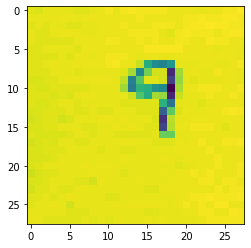

In [13]:
plt.imshow(X_train[0])
X_train[0].shape

In [14]:
y_train_new=y_train.argmax(axis=1)
y_train_new.shape
print(y_train_new.shape)
y_train=y_train_new


(16048,)


Generator 

In [15]:
def build_generator(img_shape, z_dim):

    model = Sequential()

    # Fully connected layer
    model.add(Dense(128, input_dim=z_dim))

    # Leaky ReLU activation
    model.add(LeakyReLU(alpha=0.01))

    # Output layer with tanh activation
    model.add(Dense(28 * 28 * 1, activation='tanh'))

    # Reshape the Generator output to image dimensions
    model.add(Reshape(img_shape))

    return model

**Discriminator**

In [16]:
def build_discriminator(img_shape):

    model = Sequential()

    # Flatten the input image
    model.add(Flatten(input_shape=img_shape))

    # Fully connected layer
    model.add(Dense(128))

    # Leaky ReLU activation
    model.add(LeakyReLU(alpha=0.01))

    # Output layer with sigmoid activation
    model.add(Dense(1, activation='sigmoid'))

    return model

<h4>The GAN Model   </h4>

In [17]:
def build_gan(generator, discriminator):

    model = Sequential()

    # Combined Generator -> Discriminator model
    model.add(generator)
    model.add(discriminator)

    return model

In [24]:
z_dim=100

# Build and compile the Discriminator
discriminator = build_discriminator((28,28))
discriminator.compile(loss='binary_crossentropy',
                      optimizer=Adam(),
                      metrics=['accuracy'])

# Build the Generator
generator = build_generator((28,28), z_dim)

# Keep Discriminator’s parameters constant for Generator training
discriminator.trainable = False

# Build and compile GAN model with fixed Discriminator to train the Generator
gan = build_gan(generator, discriminator)
gan.compile(loss='binary_crossentropy', optimizer=Adam())

In [29]:
losses = []
accuracies = []
iteration_checkpoints = []


def train(array,iterations, batch_size, sample_interval):

    # Load the MNIST dataset
#     (X_train, _), (_, _) = mnist.load_data()
    X_train=array
    # Rescale [0, 255] grayscale pixel values to [-1, 1]
    X_train = X_train / 127.5 - 1.0
    X_train = np.expand_dims(X_train, axis=3)

    # Labels for real images: all ones
    real = np.ones((batch_size, 1))

    # Labels for fake images: all zeros
    fake = np.zeros((batch_size, 1))

    for iteration in range(iterations):

        # -------------------------
        #  Train the Discriminator
        # -------------------------

        # Get a random batch of real images
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs = X_train[idx]

        # Generate a batch of fake images
        z = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = generator.predict(z)

        # Train Discriminator
        d_loss_real = discriminator.train_on_batch(imgs, real)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        d_loss, accuracy = 0.5 * np.add(d_loss_real, d_loss_fake)

        # ---------------------
        #  Train the Generator
        # ---------------------

        # Generate a batch of fake images
        z = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = generator.predict(z)

        # Train Generator
        g_loss = gan.train_on_batch(z, real)

        if (iteration + 1) % sample_interval == 0:

            # Save losses and accuracies so they can be plotted after training
            losses.append((d_loss, g_loss))
            accuracies.append(100.0 * accuracy)
            iteration_checkpoints.append(iteration + 1)

            # Output training progress
            print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" %
                  (iteration + 1, d_loss, 100.0 * accuracy, g_loss))

            # Output a sample of generated image
            sample_images(generator)

In [31]:


def sample_images(generator, image_grid_rows=4, image_grid_columns=4):

    # Sample random noise
    z = np.random.normal(0, 1, (image_grid_rows * image_grid_columns, z_dim))

    # Generate images from random noise
    gen_imgs = generator.predict(z)

    # Rescale image pixel values to [0, 1]
    gen_imgs = 0.5 * gen_imgs + 0.5

    # Set image grid
    fig, axs = plt.subplots(image_grid_rows,
                            image_grid_columns,
                            figsize=(4, 4),
                            sharey=True,
                            sharex=True)

    cnt = 0
    for i in range(image_grid_rows):
        for j in range(image_grid_columns):
            # Output a grid of images
            axs[i, j].imshow(gen_imgs[cnt, :, :], cmap='gray')
            axs[i, j].axis('off')
            cnt += 1



In [ ]:
# Set hyperparameters
iterations = 20000
batch_size = 128
sample_interval = 1000

# Train the GAN for the specified number of iterations
train(X_train,iterations, batch_size, sample_interval)

1000 [D loss: 1.345392, acc.: 14.84%] [G loss: 0.708077]


In [ ]:
losses = np.array(losses)

# Plot training losses for Discriminator and Generator
plt.figure(figsize=(15, 5))
plt.plot(iteration_checkpoints, losses.T[0], label="Discriminator loss")
plt.plot(iteration_checkpoints, losses.T[1], label="Generator loss")

plt.xticks(iteration_checkpoints, rotation=90)

plt.title("Training Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()